<a href="https://colab.research.google.com/github/mkbahk/QuantumComputing/blob/main/QuantumToyAlgorithm_CHSHGate_05_Genspark_mkbahk_20250414.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install qiskit[visualization]==1.2.4
%pip install qiskit-aer==0.15.1
%pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 4.8 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=c8c3bcc991ce9cdd86bce4eed7a47a03009eec904358c3c7d993ee1a4ca6b07f
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 47.1 MB/s eta 0:00:00
  Cloning https://github.com/qisk

In [35]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, assemble
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram, plot_state_city, plot_bloch_multivector
from qiskit_textbook.tools import array_to_latex
from qiskit_aer import Aer
from IPython.display import display, Math
import numpy as np

E(a,b) = 0.6973
E(a,b') = -0.6914
E(a',b) = 0.7087
E(a',b') = 0.7092
CHSH 값 S = 2.8066
이론적 최대값 = 2.8284
고전 이론 한계 = 2
결과: CHSH 부등식 위반! 양자역학의 비국소성 확인


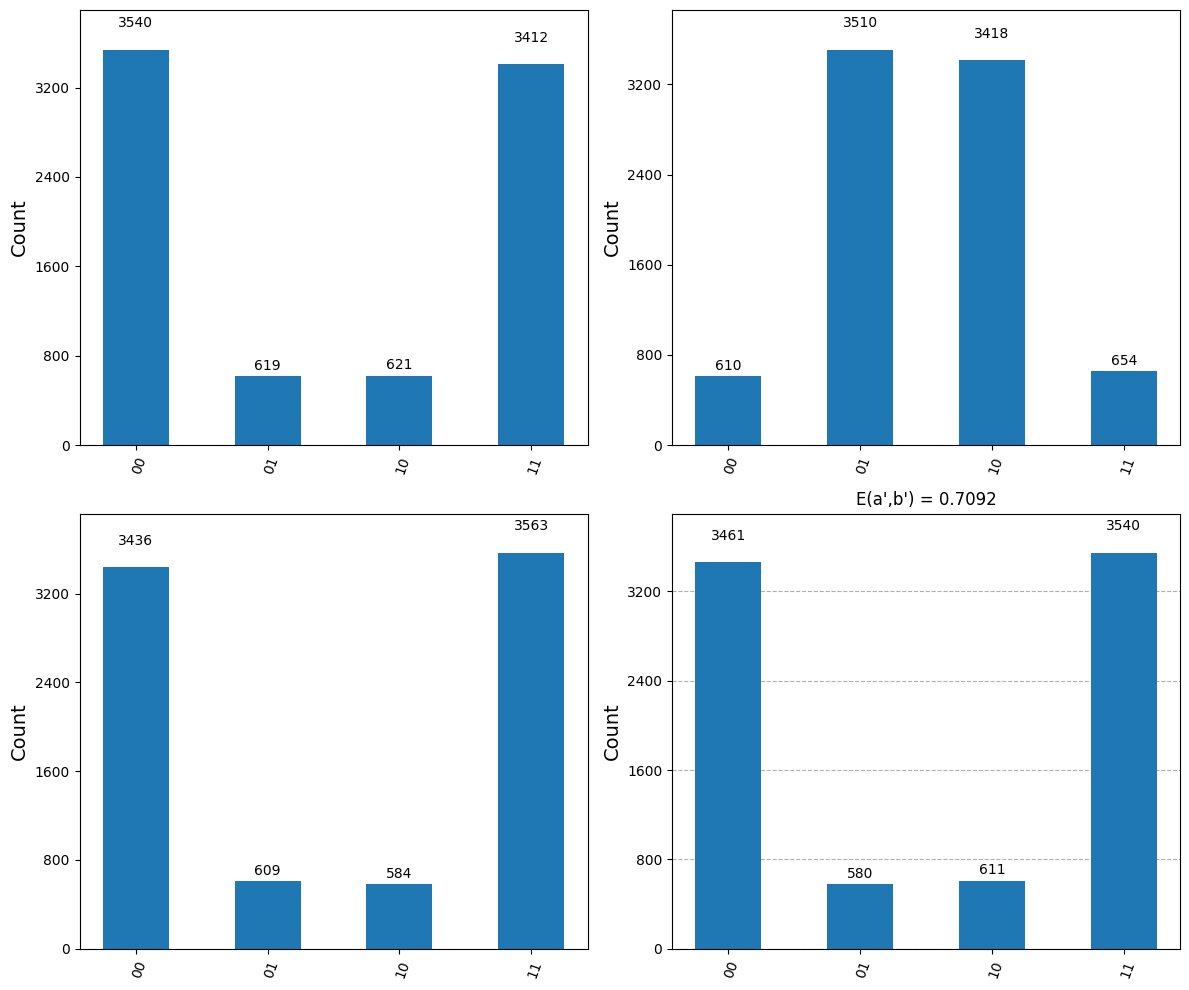

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46384 (\N{HANGUL SYLLABLE DDA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/lo

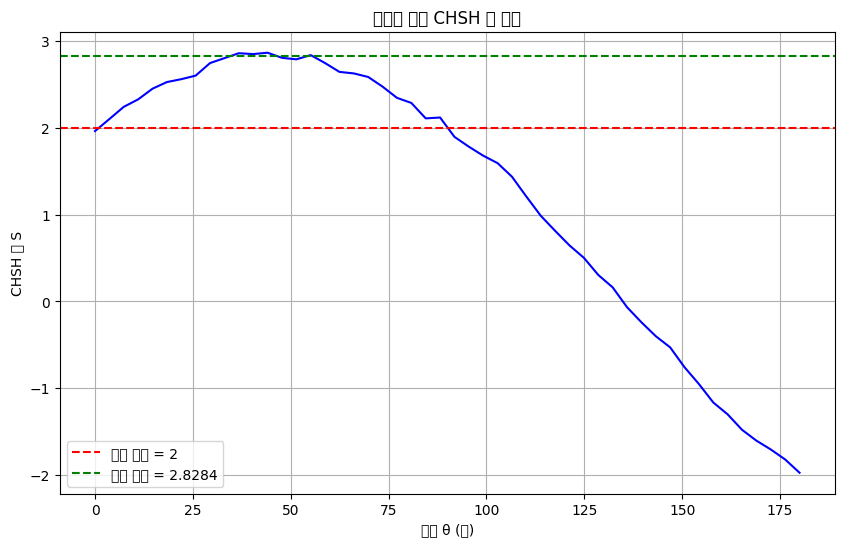

In [52]:
import matplotlib.pyplot as plt

# CHSH Game 구현을 위한 함수들

def create_bell_state():
    """
    Bell 상태 |Φ+⟩ = (|00⟩ + |11⟩)/√2 생성
    """
    qr = QuantumRegister(2, name="q")
    cr = ClassicalRegister(2, name="c")
    circuit = QuantumCircuit(qr, cr)

    # Bell 상태 생성
    circuit.h(qr[0])  # Hadamard gate on the first qubit
    circuit.cx(qr[0], qr[1])  # CNOT gate with first qubit as control and second as target

    return circuit, qr, cr
###def

def add_measurements(circuit, qr, cr, theta_a, theta_b):
    """
    Alice와 Bob의 측정을 위한 회로 추가

    theta_a: Alice의 측정 각도
    theta_b: Bob의 측정 각도
    """
    # Alice의 측정을 위한 기저 변환
    circuit.ry(-theta_a, qr[0])

    # Bob의 측정을 위한 기저 변환
    circuit.ry(-theta_b, qr[1])

    # 측정
    circuit.measure(qr, cr)

    return circuit
###def

def compute_correlation(counts, shots):
    """
    측정 결과로부터 상관 함수 E 계산

    E = (N_00 + N_11 - N_01 - N_10) / (N_00 + N_11 + N_01 + N_10)
    """
    n_00 = counts.get('00', 0)
    n_01 = counts.get('01', 0)
    n_10 = counts.get('10', 0)
    n_11 = counts.get('11', 0)

    correlation = (n_00 + n_11 - n_01 - n_10) / shots

    return correlation
###def

def run_chsh_experiment(theta_a, theta_b, shots=1024):
    """
    특정 각도에서 CHSH 실험 실행
    """
    circuit, qr, cr = create_bell_state()
    circuit = add_measurements(circuit, qr, cr, theta_a, theta_b)

    # 시뮬레이터에서 실행
    simulator = Aer.get_backend('qasm_simulator')
    result = simulator.run(circuit, shots=shots).result()
    counts = result.get_counts(circuit)

    # 상관 함수 계산
    correlation = compute_correlation(counts, shots)

    return correlation, counts
###def

def run_chsh_game():
    """
    CHSH Game 실행 및 결과 분석
    """
    # Alice와 Bob의 전략적 각도 설정
    # 이론적으로 최적의 각도는 π/4(45°)로 나뉜 간격
    a = 0           # Alice의 첫 번째 설정
    a_prime = np.pi/2  # Alice의 두 번째 설정
    b = np.pi/4     # Bob의 첫 번째 설정
    b_prime = 3*np.pi/4  # Bob의 두 번째 설정

    # 샷 수 설정
    shots = 8192

    # 각 설정에 대한 상관 함수 계산
    E_ab, counts_ab = run_chsh_experiment(a, b, shots)
    E_ab_prime, counts_ab_prime = run_chsh_experiment(a, b_prime, shots)
    E_a_prime_b, counts_a_prime_b = run_chsh_experiment(a_prime, b, shots)
    E_a_prime_b_prime, counts_a_prime_b_prime = run_chsh_experiment(a_prime, b_prime, shots)

    # CHSH 값 계산
    S = E_ab - E_ab_prime + E_a_prime_b + E_a_prime_b_prime

    # 결과 출력
    print(f"E(a,b) = {E_ab:.4f}")
    print(f"E(a,b') = {E_ab_prime:.4f}")
    print(f"E(a',b) = {E_a_prime_b:.4f}")
    print(f"E(a',b') = {E_a_prime_b_prime:.4f}")
    print(f"CHSH 값 S = {S:.4f}")
    print(f"이론적 최대값 = {2*np.sqrt(2):.4f}")
    print(f"고전 이론 한계 = 2")

    if abs(S) > 2:
        print("결과: CHSH 부등식 위반! 양자역학의 비국소성 확인")
    else:
        print("결과: CHSH 부등식 위반하지 않음")
    ###if

    # 히스토그램 표시
    fig, ax = plt.subplots(2, 2, figsize=(12, 10))
    plot_histogram(counts_ab, title=f"E(a,b) = {E_ab:.4f}", ax=ax[0, 0])
    plot_histogram(counts_ab_prime, title=f"E(a,b') = {E_ab_prime:.4f}", ax=ax[0, 1])
    plot_histogram(counts_a_prime_b, title=f"E(a',b) = {E_a_prime_b:.4f}", ax=ax[1, 0])
    plot_histogram(counts_a_prime_b_prime, title=f"E(a',b') = {E_a_prime_b_prime:.4f}", ax=ax[1, 1])
    plt.tight_layout()
    plt.show()

    return S, abs(S) > 2
###def

def plot_chsh_vs_angle():
    """
    각도에 따른 CHSH 값 플롯
    """
    angles = np.linspace(0, np.pi, 50)
    S_values = []

    for theta in angles:
        # 특정 각도 관계를 유지하면서 CHSH 값 계산
        a = 0
        a_prime = np.pi/2
        b = theta
        b_prime = theta + np.pi/2

        E_ab, _ = run_chsh_experiment(a, b)
        E_ab_prime, _ = run_chsh_experiment(a, b_prime)
        E_a_prime_b, _ = run_chsh_experiment(a_prime, b)
        E_a_prime_b_prime, _ = run_chsh_experiment(a_prime, b_prime)

        S = E_ab - E_ab_prime + E_a_prime_b + E_a_prime_b_prime
        S_values.append(S)
    ###for

    plt.figure(figsize=(10, 6))
    plt.plot(angles * 180/np.pi, S_values, 'b-')
    plt.axhline(y=2, color='r', linestyle='--', label='고전 한계 = 2')
    plt.axhline(y=2*np.sqrt(2), color='g', linestyle='--', label=f'양자 한계 = {2*np.sqrt(2):.4f}')
    plt.grid(True)
    plt.xlabel('각도 θ (도)')
    plt.ylabel('CHSH 값 S')
    plt.title('각도에 따른 CHSH 값 변화')
    plt.legend()
    plt.show()
###def


# CHSH Game 실행
S, violated = run_chsh_game()

# 각도에 따른 CHSH 값 플롯
plot_chsh_vs_angle()